---
title: "Sample Size for A/B Hypothesis Testing"
author: "chris"
date: 2024-03-31
draft: false
---

The other day I had a conversation at work about model training and evaluation metrics.  A colleague of mine suggested that the small improvements we were seeing might not actually be statistically significant.  I speculated that we could use hypothesis testing (and sampling) to determine a threshold at which an improvement was or wasn't significant.
After some research, [for various reasons](https://stats.stackexchange.com/a/626673), we concluded that this was not a good approach (see link) but the topic reminded me of an A/B testing exercise I did a few years back.  I hadn't fully documented that work, so in this post I intend to do that.  Here I'll go through a derivation for sample size as it relates to A/B testing and ultimately create a sample size calculator as a shiny app (in R).

Before I dive into a sample size derivation, I'll briefly go over what A/B testing is and describe it's components.

Put simply, an A/B Test is a form of [statistical hypothesis testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_test).  We start with a hypothesis, data is collected, then a resulting test statistic determines the validity of the hypothesis.  A hypothesis could something like "a change to my landing page will increase the number of sign-ups" and the test statistic would be sign-up rate.  The test would involve making a change to the website while collecting number of sign-ups, and the new sign-up rate would indicate if your hypothesis should be rejected or accepted. Note that in this post I'll be referring to the test statistic as a conversion rate for simplicity.  And there many other scenarios (not just website design and sign-up rate) that fit within the A/B testing framework, this is just one example.

Before performing an A/B test, there are a few parameters which are either already known or defined:

- current conversion rate
- type I error
- type II error
- minimum detectable change

Current conversion rate is the value of the test statistic without any changes (i.e. control group) and should be known apriori.  Type I and II errors are tolerance parameters you will define for the test. Type I error is the false positive rate (i.e. accept there was a change due to the treatment when there wasn't) and type II error is the false negative rate (i.e. reject there was a change due to the treatment when there was). As you might expect, the higher the tolerance for error the fewer samples you will need.  Lastly, the somewhat self explanatory minimum detectable change is the smallest change you'd like to be able to detect from the test.  Conversely, the smaller the change, the more samples you'll need. Thus, the **unknown parameters are the sample size as well as the critical value** at which to accept or reject the hypothesis.

Ok, so defining things more formally, the number of conversions would be a binomial random variable

$$ X \sim B(n, p) $$

where $n$ is number of trials (or visits in the hypothetical example above) and $p$ is the probability of a success (or sign-up).  By definition, the expected value and variance for the binomial random variable are

$$ E[X] = np, \ Var(X) = np(1 - p) $$

Since we are interested in conersion rate, we can define a new variable

$$ Y = \frac{X}{n} $$

and by properties of [expectation](https://en.wikipedia.org/wiki/Expected_value#Properties) and [variance](https://en.wikipedia.org/wiki/Variance#Basic_properties) the new parameters are

$$ E[Y] = p, \ Var(Y) = \frac{p(1 - p)}{n} $$

Now, let's define the current conversion rate as $Y_c$ and the treatment conversion rate as $Y_e$.  To make the hypothesis convenient, our test statistic will be the difference between the two $Y_d = Y_e - Y_c$, and the null hypothesis is that the expected value of this difference is zero

$$ H_0: E[Y_d] = 0 $$

and the alternative hypothesis that the difference is equal to or greater than some value $d$ (i.e. the treatment had a positive effect):

$$ H_a: E[Y_d] \ge d $$

Note that this implies a one-sided test, but there can also be a two-sided test.  A one-sided test evaluates for a change in one direction whereas two-sided test evalutes change in both directions (i.e. the change could also be negative).  This is important because it affects the critical value and thus sample size, which I'll elaborate on later.


Visual representations are always helpful, so below is the distribution of the test statistic $Y_d$ under the null hypothesis when type I error $\alpha = 0.05$.  An important note here is that I'm using a Gaussian approximation to the Binomial [which is valid when the number of samples is large enough](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation).

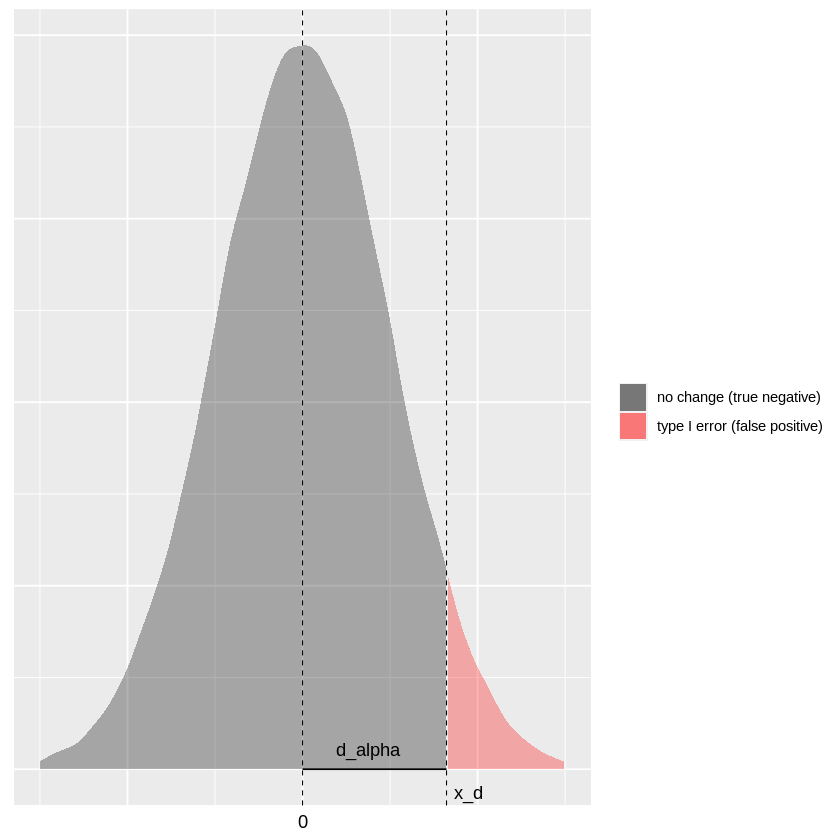

In [116]:
library(ggplot2)

mu_null <- 0
n <- 100000
alpha <- 0.05

z_alpha <- qnorm(1 - alpha)

density_null <- density(rnorm(n, mu_null, 1))
df_null <- data.frame(x = density_null$x, y = density_null$y)

ggplot() +
  geom_ribbon(data = df_null[df_null$x < z_alpha, ],
              aes(x = x, ymax = y, fill = "no change (true negative)"),
              ymin = 0, alpha = 0.3) +
  geom_ribbon(data = df_null[df_null$x >= z_alpha, ],
              aes(x = x, ymax = y, fill = "type I error (false positive)"),
              ymin = 0, alpha = 0.3) +
  scale_fill_manual(values = c("black", "red")) +
  geom_segment(aes(x = mu_null, y = 0, xend = z_alpha, yend = 0)) +
  geom_text(aes(0.75, 0, label = "d_alpha", vjust = -1)) +
  geom_vline(xintercept = 0, linetype="dashed", linewidth = 0.3) +
  geom_vline(xintercept = z_alpha, linetype="dashed", linewidth = 0.3) +
  geom_text(aes(x = 1.9, label = "\nx_d", y = 0, vjust = 0.75), angle=0) +
  scale_x_continuous(limits = c(-3, 3)) +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(),
        axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank(),
        legend.title=element_blank()) +
   xlab(mu_null)


The gray shaded region is the probability density of a true negative and the red region corresponds to a false positive. Here the variable $d_\alpha$ is the distance from the expected value under the null hypothesis to the critical value $x_d$.  This distance depends upon the allowable type I error $\alpha$.

Now let's take a look at the alternative hypothesis for $d = 0.4$ and a type II error $\beta = 0.20$.

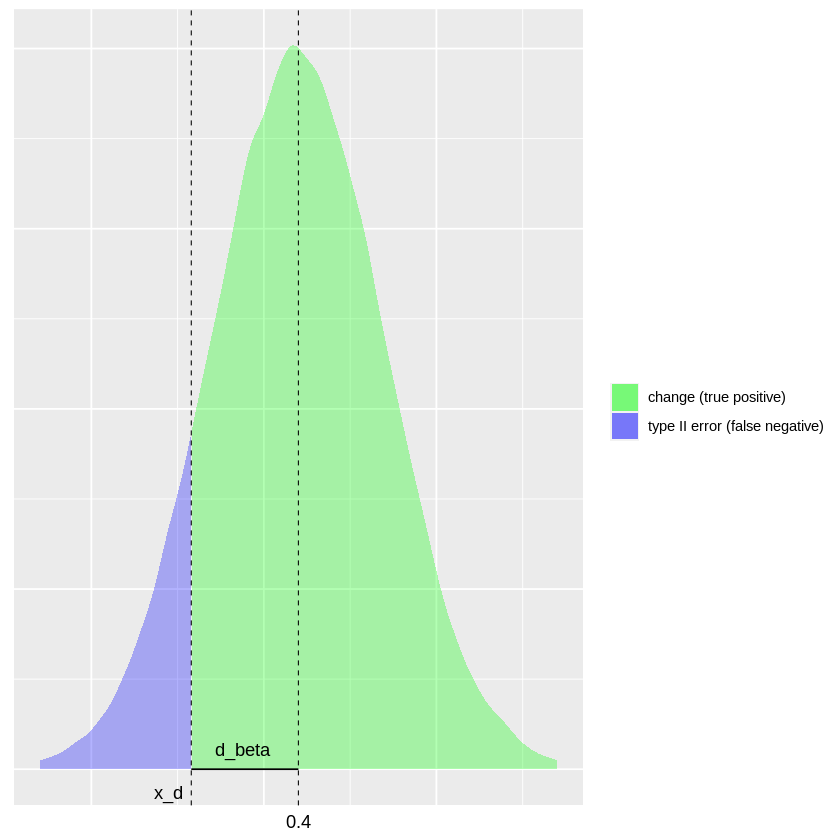

In [111]:
mu_alt <- 0.4
n <- 100000
beta <- 0.20

z_beta <- qnorm(1 - beta)

density_alt <- density(rnorm(n, mu_alt, 1))
df_alt <- data.frame(x = density_alt$x, y = density_alt$y)

ggplot() +
  geom_ribbon(data = df_alt[df_alt$x > -z_beta, ],
              aes(x = x, ymax = y, fill = "change (true positive)"),
              ymin = 0, alpha = 0.3) +
  geom_ribbon(data = df_alt[df_alt$x <= -z_beta, ],
              aes(x = x, ymax = y, fill = "type II error (false negative)"),
              ymin = 0, alpha = 0.3) +
  scale_fill_manual(values = c( "green", "blue")) +
  geom_segment(aes(x = mu_alt, y = 0, xend = -z_beta, yend = 0)) +
  geom_text(aes(-0.25, 0, label = "d_beta", vjust = -1)) +
  geom_vline(xintercept = mu_alt, linetype="dashed", linewidth = 0.3) +
  geom_vline(xintercept = -z_beta, linetype="dashed", linewidth = 0.3) +
  geom_text(aes(x = -1.1, label = "\nx_d", y = 0, vjust = 0.75), angle=0) +
  scale_x_continuous(limits = c(-3 + mu_alt, 3 + mu_alt)) +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(),
        axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank(),
        legend.title=element_blank()) +
  xlab(mu_alt)

The green shaded region is the probability density of a true positive and the blue region corresponds to a false negative. Akin to the previous plot, the variable $d_\beta$ defines the distance from the expected value under the alternative hypothesis to the critical value $x_d$.  This distance depends upon the allowable type II error $\beta$.

If you look closely, you can see that the critival value allows us to relate both distances to the minimum detectable change $d$.

$$d = d_\alpha + d_\beta$$

Again, $d$ is the difference between the expected value under the null hypothesis and the expected value under the alternative hypothesis.  And it's not immediately clear how defining these distances will help us determine sample size and critival value but we'll see below.

In order to quantify $d_\alpha$ and $d_\beta$, we need the expected value and variance of the test statistic $Y_d$ under the null and alternative hypothesis.  The expected value is pretty straighforward

$$ E[Y_d] = E[Y_e] - E[Y_c] = p_e - p_c $$

whereas the variance is (assuming equal number of samples)

$$ Var(Y_d) = Var(Y_e) + Var(Y_c) = \frac{p_e(1 - p_e)}{n} + \frac{p_c(1 - p_c)}{n} $$

So, to elaborate on our hypothesis, under the null where $p_e = p_c$ we have

$$ H_0: E[Y_d] = 0, \ Var(Y_d) = \frac{2p_c(1 - p_c)}{n} $$

and under the alternative there is

$$ H_a: E[Y_d] \le d, \ Var(Y_d) = \frac{p_c(1 - p_c) + p_e(1 - p_e)}{n} $$

Using the Gaussian approximation as noted above, we can define the following distances

$$ d_\alpha = Z_{1-\alpha} \sqrt{\frac{2p_c(1-p_c)}{n}} $$

$$ d_\beta = Z_{1-\beta}\sqrt{\frac{p_c(1 - p_c) + p_e(1 - p_e)}{n}} $$

and some rearranging to isolate $n$ our variable of interest

$$ d_\alpha = \frac{1}{\sqrt{n}} Z_{1-\alpha} \sqrt{2p_c(1-p_c)} $$

$$ d_\beta = \frac{1}{\sqrt{n}} Z_{1-\beta} \sqrt{p_c(1-p_c) + p_e(1-p_e)} $$

Now we can define the minimum detectable effect as

$$ d = \frac{1}{\sqrt{n}} \biggl( Z_{1-\alpha} \sqrt{2p_c(1-p_c)} + Z_{1-\beta} \sqrt{p_c(1-p_c) + p_e(1-p_e)} \biggr) $$

and solving for $n$, the sample size of the test is

$$ n = \biggl( \frac{Z_{1-\alpha} \sqrt{2p_c(1-p_c)} + Z_{1-\beta} \sqrt{p_c(1-p_c) + p_e(1-p_e)}}{d} \biggr) ^2 $$

where the critical value to acceptor reject the null hypothesis is

$$ x_d = p_c + d_\alpha = p_c + Z_{1-\alpha} \sqrt{\frac{2p_c(1-p_c)}{n}} $$

It's important to re-iterate that this sample size calculation is for a one-sided test and a scenario where the change in rate is expected to be positive.  If we expected a negative change in rate, the minimum detectable effect $d$ would be negative and the equality in the alternative hypothesis flipped.

For a two-sided test, Z-score corresponding to the $\alpha$ value would need to divided in half in order to account for false positives in both directions.  Another important caveat under the two-sided alternative hypothesis is that variance could take on two different values.  For instance, the alternative conversion rate $p_e$ could be equal to either $p_c + d$ or $p_c - d$ each of which implies a different variance and thus sample size.  To make this clear, here is a plot of variance of as a function $p_e$ (recall this is $E[Y_e]$).

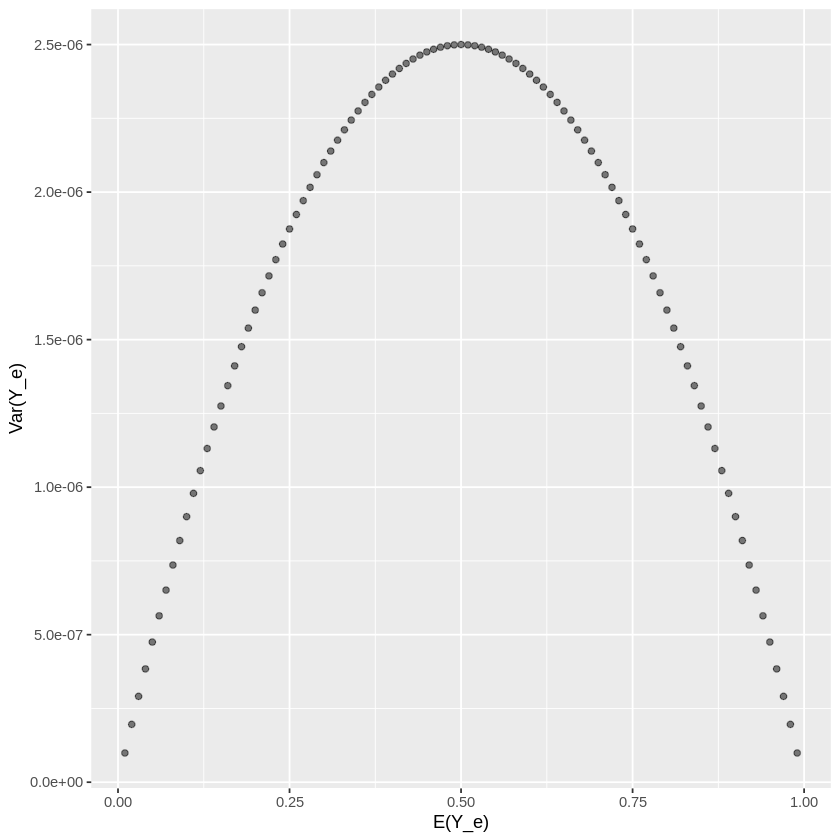

In [132]:
# plot of variance for alternative hypothesis as a function E(Y_e)

mu_e = seq(0.01, 0.99, by=0.01)  # i.e. p_e

var_e_fn <- function(p_e) {
  return(p_e * (1 - p_e) / n)
}

var_e = sapply(mu_e, var_e_fn)

ggplot(data = data.frame(x = mu_e, y = var_e)) +
  geom_point(aes(x = x, y = y), alpha = 0.5) +
  xlab("E(Y_e)") + ylab("Var(Y_e)")

So, if we are performing a two-sided test, in order to be conservative, we should choose the value of $p_e$ that maximizes the variance and sample size.  As you can see above, this amounts to choosing the value of $p_e$ which is closest to $\frac{1}{2}$.

The following is a link to a sample size calculator I created in R using shiny.  Note that this doesn't yet display the critical value but that is scheduled for a second pass.

https://cbhyphen.shinyapps.io/ab-test-sample-size-calculator/